In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler 

import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

Using data from: 
https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand


In [106]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("../data_files/SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1) # removing some columns that we don't care about

In [107]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int) # converting yes to 1
df = df[df["hour"] == 12] # looking only at noon
df = df.drop(["hour"], axis = 1) # dropping the hour column, since all = 12


In [108]:
df.head

<bound method NDFrame.head of       bike_count  temp  humidity  wind  visibility  dew_pt_temp  radiation  \
12           449   1.7        23   1.4        2000        -17.2       1.11   
36           479   4.3        41   1.3        1666         -7.8       1.09   
60           333   5.8        85   1.7         349          3.4       0.43   
84           393  -0.3        38   4.8        1823        -12.9       1.11   
108          321  -2.3        25   0.0        1962        -19.7       0.00   
...          ...   ...       ...   ...         ...          ...        ...   
8652         752   9.1        57   1.1         562          1.0       1.69   
8676         672   9.3        61   1.5         390          2.1       0.85   
8700         635   7.9        14   1.7        1688        -18.0       1.81   
8724         661   5.6        27   0.3        1522        -11.9       0.34   
8748         720   6.6        35   1.3        1409         -7.8       1.70   

      rain  snow  functional  
12

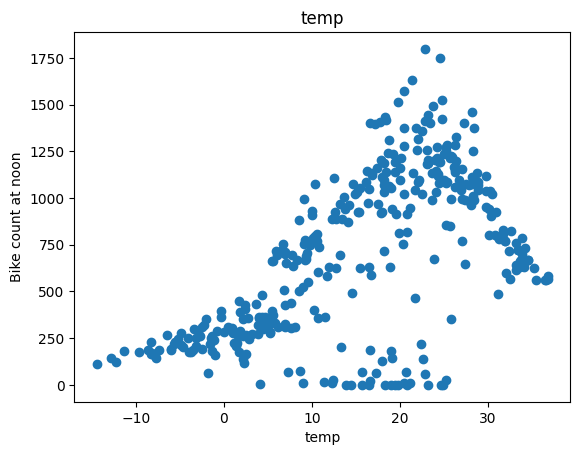

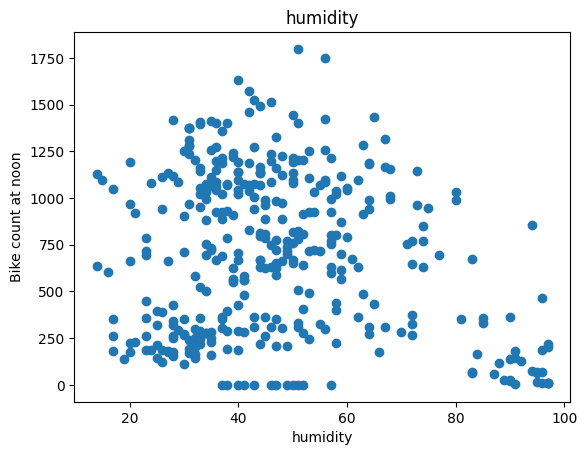

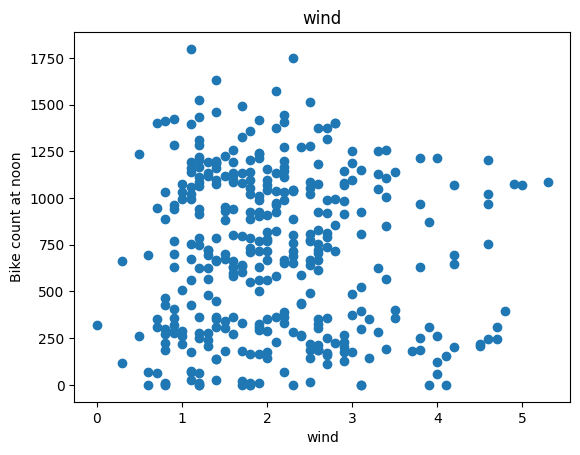

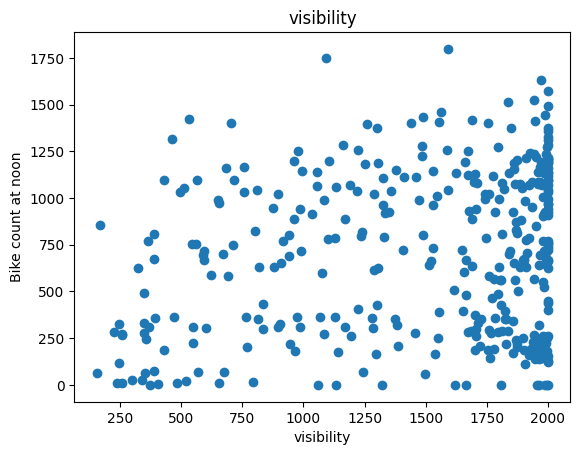

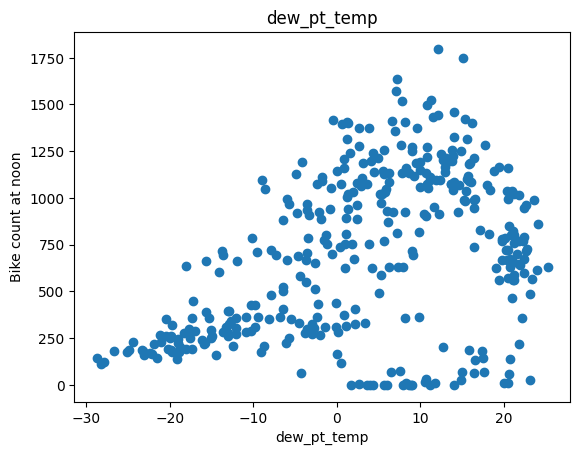

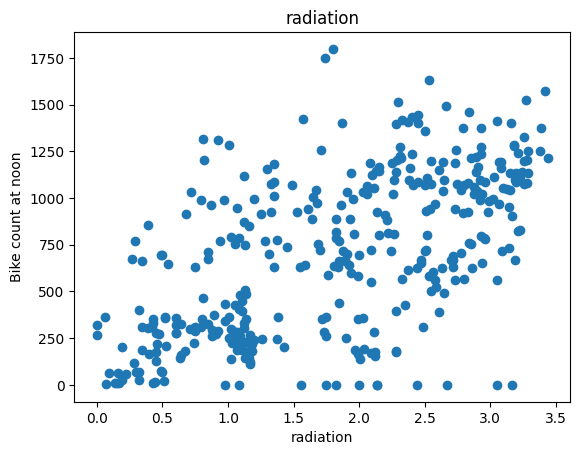

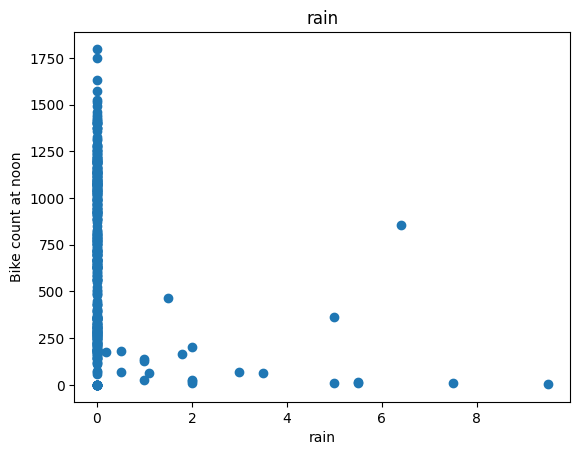

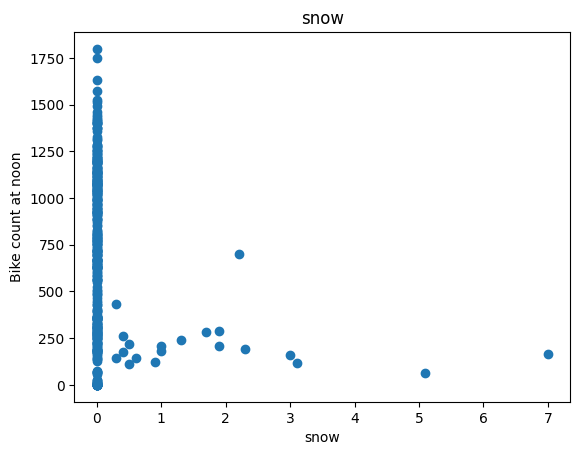

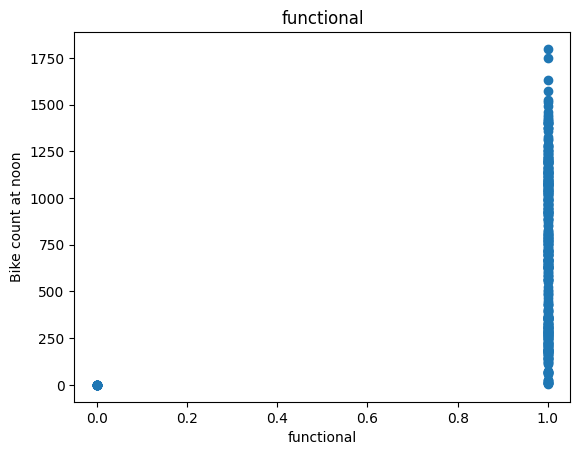

In [109]:
# first, we can look at all the data and see which have a linear looking plot
# we are looking for data that does not seem too helpful, and then we can drop it
for label in df.columns[1:]: # everything from temperature onward
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.ylabel("Bike count at noon")
    plt.xlabel(label)
    plt.show()

In [110]:
df = df.drop(["wind", "visibility", "functional"], axis = 1)

In [111]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train / validate test
Now, we'll split this data into different sets. 

In [112]:
train, val, test = np.split(df.sample(frac = 1), [int(0.6 * len(df)), int(0.8 * len(df))])

/Users/jacksonpowell/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [113]:
def get_xy(dataframe, y_label, x_labels = None): # used to extract data for just whatever youre interested in
    dataframe = copy.deepcopy(dataframe) # copies entire dataframe
    if x_labels is None: 
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else: 
        if len(x_labels) == 1: 
            X = dataframe[x_labels[0]].values.reshape(-1,1)
        else: 
            X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X, y))

    return data, X, y

In [114]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels = ["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels = ["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels = ["temp"])

In [115]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [116]:
temp_reg.score(X_test_temp, y_test_temp) # pretty garbage

0.4097722568384674

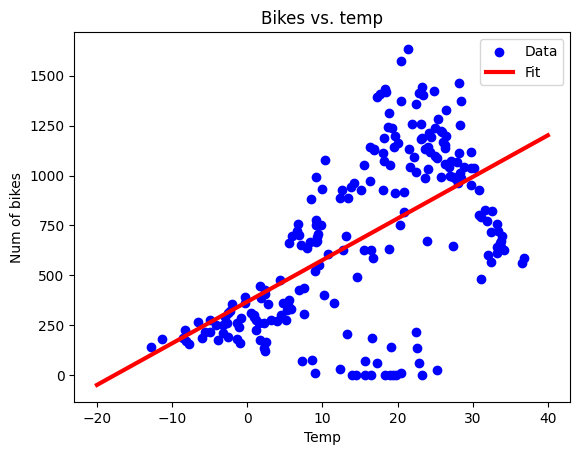

In [117]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes vs. temp")
plt.ylabel("Num of bikes")
plt.xlabel("Temp")
plt.show()

# Multiple linear regression

In [118]:
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels = df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels = df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels = df.columns[1:])

In [119]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [120]:
all_reg.score(X_test_all, y_test_all)

0.5216096536602455

# Regression with NN
Here we use tensor flow again.

In [121]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch') # Epoch is a training cycle, so we plot loss over training cycles
    plt.ylabel('MSE')
    plt.legend
    plt.grid(True)

    plt.show()

In [122]:
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [123]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer, 
    tf.keras.layers.Dense(1) # using a single node is linear
])

In [124]:
temp_nn_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.1), loss = "mean_squared_error")

In [125]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp, 
    verbose = 0, 
    epochs = 1000, 
    validation_data = (X_val_temp, y_val_temp)
)

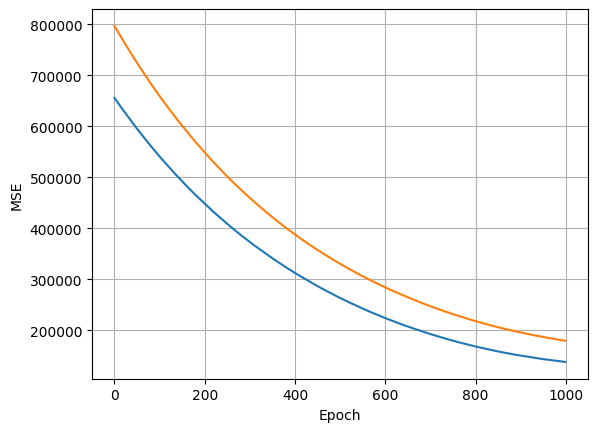

In [126]:
plot_loss(history)

4/4 [==============================] - 0s 794us/step


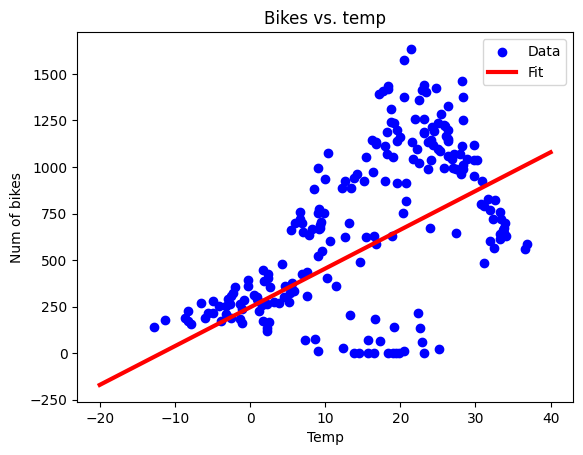

In [127]:
# The fit here will be slightly different, as we are using back propagation to train a neural net node
# That differs from the previous, which simply tries to compute the line of best fit
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes vs. temp")
plt.ylabel("Num of bikes")
plt.xlabel("Temp")
plt.show()